# Burger's Inviscid/Non-Linear Advection

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \mu\frac{\partial^2 u}{\partial x^2}
$$

with 
$$
u(x, 0) = \begin{cases}
    1 & x < \pi/2\\
    sin(x) & \pi/2 \le x \le 3\pi/2\\
    -1 & x > 3\pi/2
\end{cases}
$$

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Define the initial signal that is being advected
def signal(x):
    u = np.zeros_like(x)
    lower = x < np.pi/2
    upper = x > 3*np.pi/2
    inside = np.logical_not(np.logical_or(lower, upper))
    u[lower] = 1
    u[upper] = -1
    u[inside] = np.sin(x[inside])
    return u

In [12]:
def plot_opts(ax, max_x):
    ticks = np.arange(0, max_x + np.pi/2, np.pi/2)
    make_label = lambda p: '$%.1f\pi$' % (p/np.pi)
    labels = list(map(make_label, ticks))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.grid()

In [118]:
# Making sure our signal function is correct. 
# fig, ax = plt.subplots(figsize=(15, 10))
# x0 = np.linspace(0, 2*np.pi, 500)
# u0 = signal(x0)
# ax.plot(x0, u0)
# ax.set_ylim(-1.5, 1.5)
# plot_opts(ax, max(x0))
# plt.show()

In [14]:
# Helper functions
def flux(u):
    return 0.5*u**2
def max_speed(u):
    return np.max(np.abs(u))
def calc_dt(u, cfl, dx):
    """Calculate delta t from CFL."""
    return cfl*dx/max_speed(u)

In [33]:
# Constant
DX = 0.1
GRID_LENGTH = np.pi*2
MU = 0.1

In [124]:
def solve(cfl, dx, mu, tf, scheme):
    # 2 ghost cells on each side
    ghost = 2
    x = np.arange(0 - ghost*dx, GRID_LENGTH + dx + ghost*dx, dx)
    start = ghost
    end = len(x) - ghost
    u = signal(x)
    cnt = 0
    t = 0
    while t < tf:
        dt = min(calc_dt(u, cfl, dx), tf - t)
        t += dt
        u = scheme(u, dt, dx, mu)
        cnt += 1
        if cnt >= 10000:
            print("max number of iterations reached.")
            print("t = %.2f" % t)
            break
    else: # Print the last time step
        print("Last time step: %.3f" % dt)
        lastcfl = max_speed(u)*dt/dx
        print("Last CFL: %.2f" % lastcfl)
        print("Number of iterations: %i" % cnt)
    
    return x, u

In [125]:
def mccormack(u, dt, dx, mu):
    l = len(u)
    r = mu*dt/(dx**2)
    # Predictor
    ubar = u.copy()
    for j in range(1, l - 1):
        ubar[j] = u[j] - (dt/dx)*(flux(u[j+1]) - flux(u[j]))
        ubar[j] += r*(u[j + 1] - 2*u[j] + u[j - 1])
    # Corrector
    u2 = u.copy()
    for j in range(2, l - 2):
        u2[j] = 0.5*(u[j] + ubar[j] - (dt/dx)*(flux(ubar[j]) - flux(ubar[j-1])))
        u2[j] += 0.5*r*(ubar[j + 1] - 2*ubar[j] + ubar[j - 1]) 
    return u2

In [126]:
def roe(u, dt, dx, mu):
    l = len(u)
    r = mu*dt/(dx**2)
    u2 = u.copy()
    for j in range(1, l - 1):
        u2[j] = u[j] - 0.25*(dt/dx)*(
            u[j+1]**2 - u[j-1]**2
            - np.abs(u[j] + u[j+1])*(u[j+1] - u[j])
            + np.abs(u[j] + u[j-1])*(u[j] - u[j-1])
        )
        u2[j] += r*(u[j+1] - 2*u[j] + u[j-1])
    return u2

In [127]:
def lax_wendroff(u, dt, dx, mu):
    l = len(u)
    r = mu*dt/(dx**2)
    f = flux(u)
    u1 = u.copy()
    for j in range(2, l - 2):
        u1[j] = 0.5*(u[j+1] - u[j-1]) - (dt/dx)*(f[j+1] - f[j-1])
        u1[j] += r*(0.5*(u[j-2] + u[j+2]) - u[j])
    u2 = u.copy()
    f1 = flux(u1)
    for j in range(3, l - 3):
        u2[j] = u[j] - (dt/dx)*(f[j+1] - f[j-1])
        u2[j] += r*(u[j+1] - 2*u[j] + u[j-1])
    return u2

In [143]:
def plot(cfl, dx, mu, tf, filename=None):
    x, u_lw = solve(cfl, dx, mu, tf, lax_wendroff)
    x, u_mc = solve(cfl, dx, mu, tf, mccormack)
    _, u_r = solve(cfl, dx, mu, tf, roe)
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(x, u_lw, 'b', label='Lax-Wendroff')
    ax.plot(x, u_mc, 'g', label='MacCormack')
    ax.plot(x, u_r, 'm', label='Roe')
    ax.set_ylim(-1.5, 1.5)
    plot_opts(ax, max(x0))
    ax.plot(x, signal(x), 'k--', label='Initial')
    ax.set_title('CFL=%.2f, $\mu$=%.2f' % (cfl, mu))
    ax.legend(fancybox=True, loc='best')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')
    if filename:
        fig.savefig(filename)

Last time step: 0.020
Last CFL: 0.20
Number of iterations: 667
Last time step: 0.020
Last CFL: 0.20
Number of iterations: 667
Last time step: 0.020
Last CFL: 0.20
Number of iterations: 667


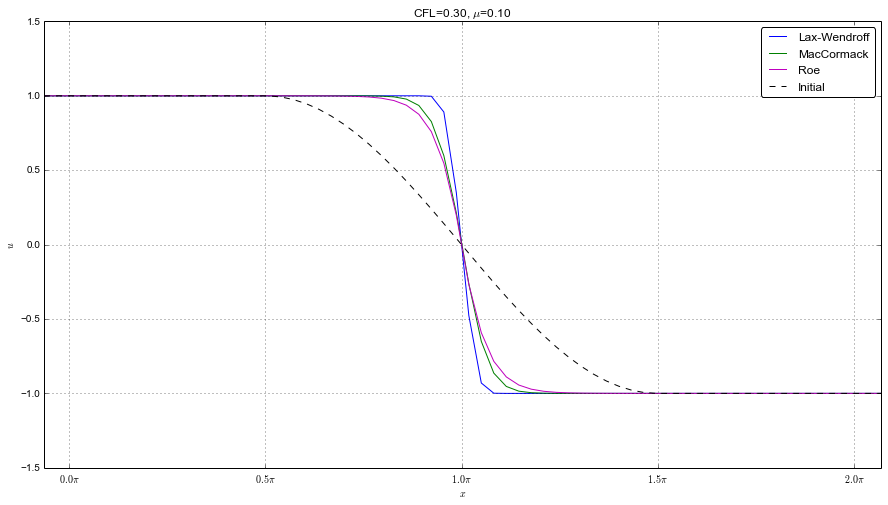

In [144]:
cfl = 0.3; dx = 0.1; mu = 0.1; tf = 20
plot(cfl, dx, mu, tf)

Last time step: 0.000
Last CFL: 0.00
Number of iterations: 1001
Last time step: 0.000
Last CFL: 0.00
Number of iterations: 1001
Last time step: 0.000
Last CFL: 0.00
Number of iterations: 1001


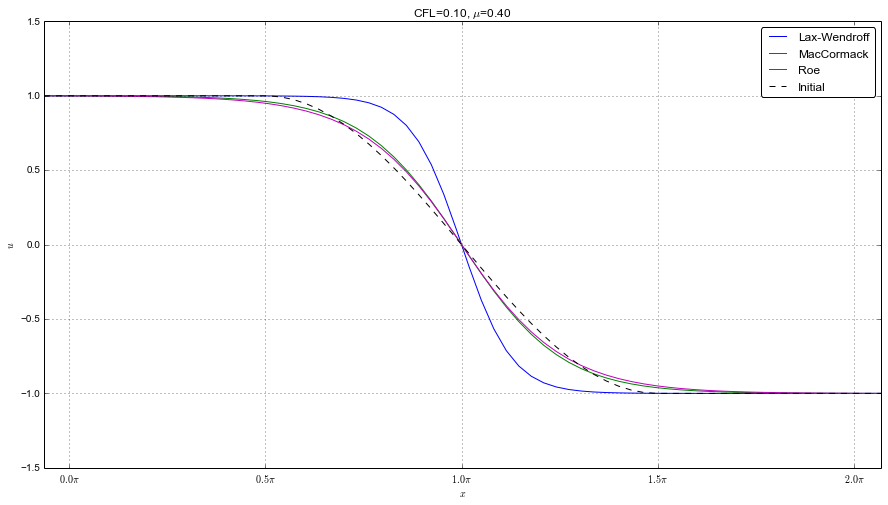

In [145]:
cfl = 0.1; dx = 0.1; mu = 0.4; tf = 10
plot(cfl, dx, mu, tf)

Last time step: 0.001
Last CFL: 0.01
Number of iterations: 5000
Last time step: 0.001
Last CFL: 0.01
Number of iterations: 5000
Last time step: 0.001
Last CFL: 0.01
Number of iterations: 5000


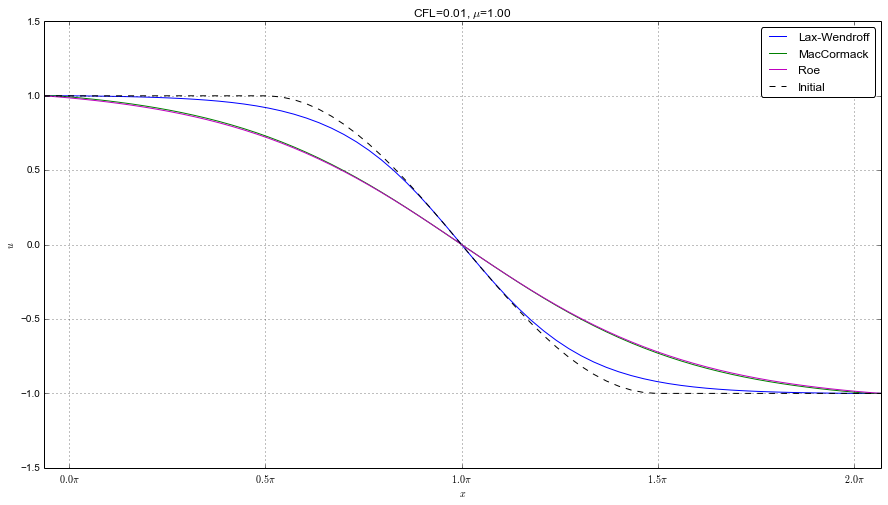

In [146]:
cfl = 0.01; dx = 0.1; mu = 1; tf = 5
plot(cfl, dx, mu, tf)

max number of iterations reached.
t = 1.00
max number of iterations reached.
t = 1.00
max number of iterations reached.
t = 1.00


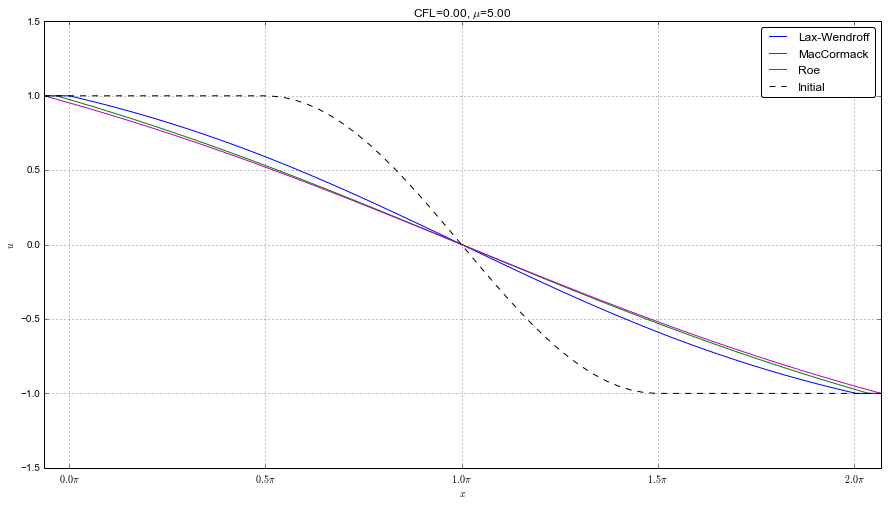

In [148]:
cfl = 0.001; dx = 0.1; mu = 5; tf = 1
plot(cfl, dx, mu, tf)